In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import canny
import geopandas as gpd
from scipy.signal import savgol_filter
from datetime import datetime

gdf = gpd.read_file("PASTIS/metadata.geojson")

In [2]:
RGB_COLOR = [2, 1, 0]
AGRI_COLOR = [6, 8, 2]
EVI2_COLOR = [10]

In [3]:
def get_images_and_dates(iloc: int):
    def dates_to_days(dates):
        dates = [str(date) for date in dates]
        date_objs = [datetime.strptime(date, "%Y%m%d") for date in dates]
        days_diff = [(date - date_objs[0]).days for date in date_objs]
        days_diff_array = np.array(days_diff)

        return days_diff_array + 1

    sample_id = gdf.iloc[iloc].ID_PATCH
    dates = dates_to_days(list(gdf.iloc[iloc]["dates-S2"].values()))

    ts = np.load(f"PASTIS/DATA_S2/S2_{sample_id}.npy")
    ts = np.moveaxis(ts, 1, -1)

    ts = np.clip((ts / 10000) * np.pi, 0, 1)

    # cloud removal
    ts[ts[:, :, :, 0] > 0.5] = np.nan  # blue band cut (for cloud detection)
    ts[ts[:, :, :, 6] < 0.3] = np.nan  # nir band cut (for cloud shadow)

    keeped = np.isnan(ts).mean(axis=(1, 2, 3)) < 0.3
    dates = dates[keeped]
    ts = ts[keeped]

    # first image cloud imputation
    first_img_nan_mask = np.isnan(ts[0])
    ts[0][first_img_nan_mask] = np.take(
        np.nanmean(ts[0], axis=(0, 1)), np.where(first_img_nan_mask)[-1]
    )

    # other images cloud imputation
    for i in range(1, ts.shape[0]):
        nan_mask = np.isnan(ts[i])
        ts[i][nan_mask] = ts[i - 1][nan_mask]

    # smoothing bands
    ts = savgol_filter(ts, window_length=11, polyorder=3, axis=0)

    # adding EVI2
    NIR = ts[:, :, :, 6]
    RED = ts[:, :, :, 2]
    EVI2 = 2.5 * (NIR - RED) / (NIR + 2 * RED + 1)
    ts = np.concatenate((ts, EVI2[:, :, :, np.newaxis]), axis=-1)

    # keeping values between 0 and 1
    ts = np.clip(ts, 0, 1)

    return ts, dates

In [4]:
def plot_images_and_dates(ts, dates, color=EVI2_COLOR):
    plots_per_row = min(8, np.ceil(ts.shape[0] / 2).astype(int))
    rows = np.ceil(ts.shape[0] / plots_per_row).astype(int)
    fig, axs = plt.subplots(rows, plots_per_row, figsize=(plots_per_row * 4, rows * 3))

    for row in range(rows):
        for col in range(plots_per_row):
            axs[row, col].set_xticks([])
            axs[row, col].set_yticks([])

            abs_index = row * plots_per_row + col

            if abs_index < ts.shape[0]:
                axs[row, col].imshow(ts[abs_index][:, :, color])
                axs[row, col].set_title(f"ts={dates[abs_index]}")
            else:
                fig.delaxes(axs[row, col])

In [19]:
def plot_reference_segmentations(iloc: int, ax=None):
    sample_id = gdf.iloc[iloc].ID_PATCH
    segmentation = np.load(f"PASTIS/ANNOTATIONS/ParcelIDs_{sample_id}.npy")

    ax.imshow(canny(segmentation / np.max(segmentation), sigma=1), cmap=plt.cm.gray)

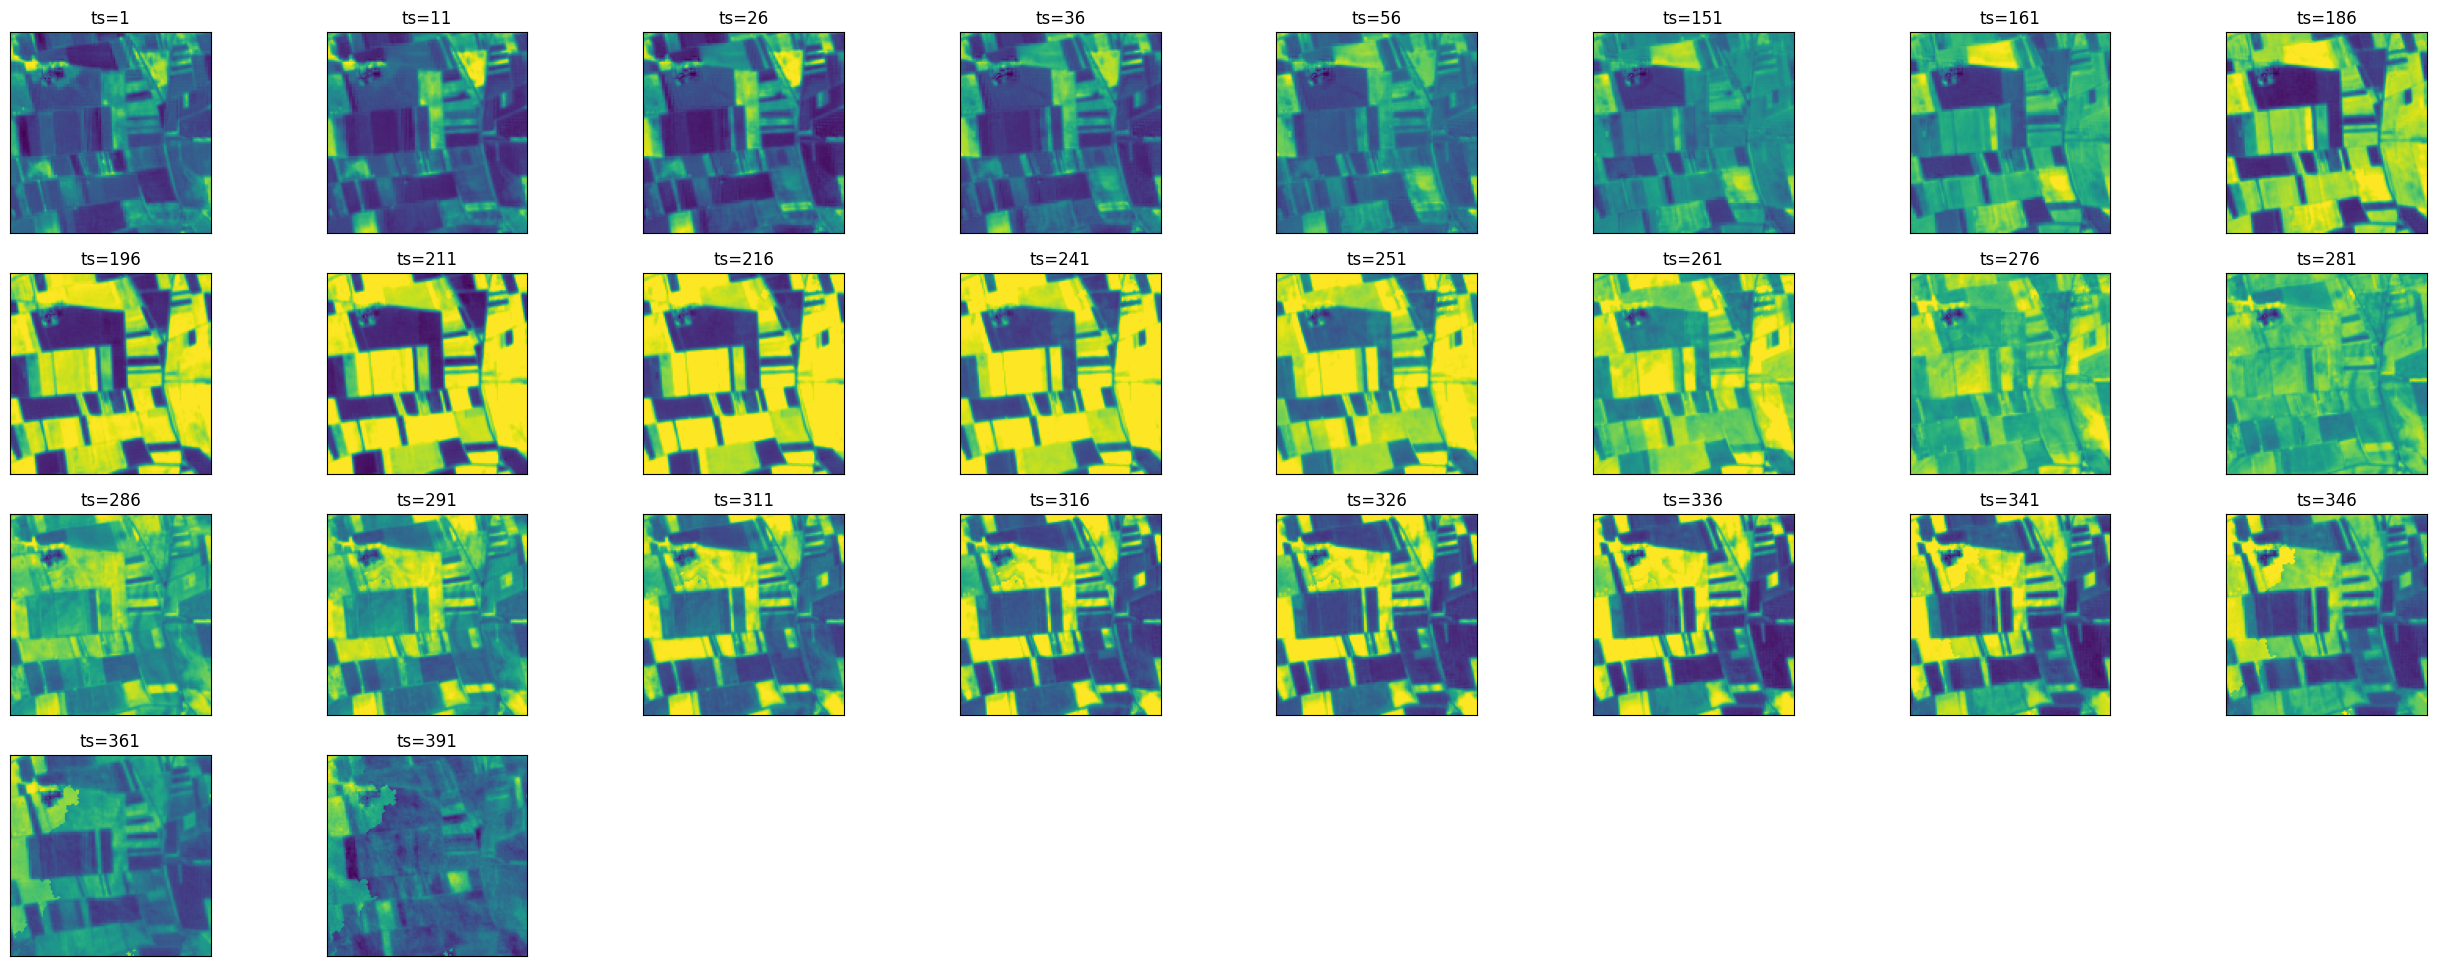

In [6]:
# 1500, 2000

iloc = 2000
ts, dates = get_images_and_dates(iloc)
plot_images_and_dates(ts, dates)

In [9]:
def extract_features(ts, dates):
    def get_single_band_from_indices(ts, indices, band_number):
        draw = np.empty((128, 128), dtype=np.float32)
        for i in range(128):
            for j in range(128):
                draw[i, j] = ts[indices[i, j], i, j, band_number]

        return draw

    def replace_zeros_with_ones(array):
        array[array == 0] = 1
        return array

    evi2_argmax = np.argmax(ts[:, :, :, EVI2_COLOR], axis=0).squeeze()

    vp_dates = dates[evi2_argmax]
    evi2_max = np.max(ts[:, :, :, EVI2_COLOR], axis=0).squeeze()
    evi2_min = np.min(ts[:, :, :, EVI2_COLOR], axis=0).squeeze()

    vp_blue = get_single_band_from_indices(ts, evi2_argmax, 0)
    vp_green = get_single_band_from_indices(ts, evi2_argmax, 1)
    vp_red = get_single_band_from_indices(ts, evi2_argmax, 2)
    vp_re1 = get_single_band_from_indices(ts, evi2_argmax, 3)
    vp_re2 = get_single_band_from_indices(ts, evi2_argmax, 4)
    vp_re3 = get_single_band_from_indices(ts, evi2_argmax, 5)
    vp_nir = get_single_band_from_indices(ts, evi2_argmax, 6)
    vp_re4 = get_single_band_from_indices(ts, evi2_argmax, 7)
    vp_swir1 = get_single_band_from_indices(ts, evi2_argmax, 8)
    vp_swir2 = get_single_band_from_indices(ts, evi2_argmax, 9)

    sen_ratio = vp_dates / np.max(vp_dates)

    evi2_gain = (evi2_max - ts[0, :, :, EVI2_COLOR].squeeze()) / vp_dates
    evi2_loss = (evi2_max - ts[-1, :, :, EVI2_COLOR].squeeze()) / (
        replace_zeros_with_ones(np.max(dates) - vp_dates)
    )

    return np.stack(
        [
            sen_ratio,
            evi2_gain,
            evi2_loss,
            evi2_max,
            evi2_min,
            vp_blue,
            vp_green,
            vp_red,
            vp_re1,
            vp_re2,
            vp_re3,
            vp_nir,
            vp_re4,
            vp_swir1,
            vp_swir2,
        ],
        axis=-1,
    )

In [10]:
features = extract_features(ts, dates)

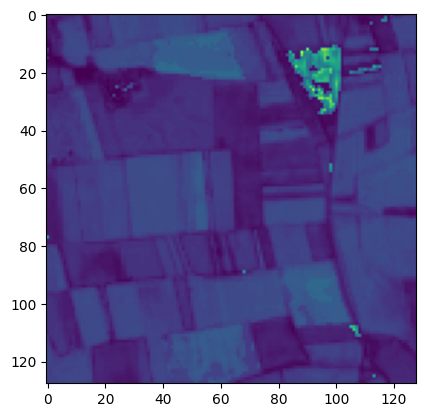

In [30]:
plt.imshow(features[:,:,1])

In [11]:
def calculate_euclidean_distance(image, position1, position2):
    bands_pixel1 = image[position1]
    bands_pixel2 = image[position2]
    
    distance = np.linalg.norm(bands_pixel1 - bands_pixel2)
    
    return distance

In [12]:
def bfs_skeletonize_rs_features(features: np.ndarray) -> np.ndarray:
    def get_neighbors(i, j):
        moves = [(0, 1), (0, -1), (1, 0), (-1, 0)]
        moves = [(i + x, j + y) for x, y in moves]
        moves = list(filter(lambda x: 0 <= x[0] < features.shape[0] and 0 <= x[1] < features.shape[1], moves))
        return moves

    visited = np.zeros((features.shape[0], features.shape[1]), dtype=bool)
    skeleton = np.zeros((features.shape[0], features.shape[1]), dtype=bool)

    def bfs_from_a_point(x, y):
        stack = [(x, y)]
        visited[x, y] = True

        while stack:
            x, y = stack.pop()

            for i, j in get_neighbors(x, y):
                if not visited[i, j]:
                    if calculate_euclidean_distance(features, (x, y), (i, j)) < 0.15:
                        stack.append((i, j))
                    else:
                        skeleton[i, j] = True 
                    visited[i, j] = True

    while (~visited).any():
        indexes = np.where(~visited)
        bfs_from_a_point(indexes[0][0], indexes[1][0])

    return skeleton

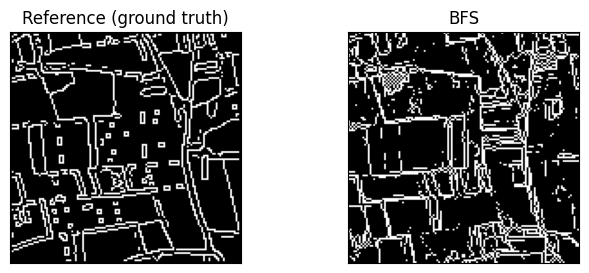

In [23]:
_, ax = plt.subplots(1, 2, figsize=(8, 3))

plot_reference_segmentations(iloc, ax[0])
ax[1].imshow(bfs_skeletonize_rs_features(features), cmap=plt.cm.gray)

for aax in ax:
    aax.set_xticks([])
    aax.set_yticks([])

ax[0].title.set_text("Reference (ground truth)")
ax[1].title.set_text("BFS")